<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S15AP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
import os, sys, io
from zipfile import ZipFile, ZIP_STORED
from PIL import Image
import numpy as np

def overlay_fg_on_bg():
  bg_dir = "/content/gdrive/My Drive/Colab Notebooks/EVA4/S15A/bg/"
  bg_imgs = sorted(os.listdir(bg_dir))
  fg_dir = "/content/gdrive/My Drive/Colab Notebooks/EVA4/S15A/fg/"
  fg_imgs = sorted(os.listdir(fg_dir))
  fg_masks_dir = "/content/gdrive/My Drive/Colab Notebooks/EVA4/S15A/fg_mask/"
  assert(len(bg_imgs) == 100)
  assert(len(fg_imgs) == 100)
  for bidx, bg_img in enumerate(bg_imgs):
    out_zip = ZipFile('fg_bg.zip', mode='a', compression=ZIP_STORED)
    label_info = open(f'fg_bg_labels.txt', 'w+')
    idx = 4000 * bidx
    print(f'Processing BG {bidx}')
    mbg = Image.open(bg_dir + bg_img)     
    
    
    for fidx, fg_img in enumerate(fg_imgs):
      mfg = Image.open(fg_dir + fg_img) 
                     
      should_flip = True
      assert(fg_img[-4:] == ".png")
      path = fg_masks_dir + fg_img[:-4] + ".jpg"
      path = path.replace("fg","frg")
      mfg_mask = Image.open(path)           

      for i in range(20):
        for should_flip in [True, False]:
          bg = mbg.copy()
          fg = mfg.copy()
          fg_mask = mfg_mask.copy()

          if should_flip:
            fg = fg.transpose(Image.FLIP_LEFT_RIGHT)
            fg_mask = fg_mask.transpose(Image.FLIP_LEFT_RIGHT)

            bg_w, bg_h = bg.size
            fg_w, fg_h = fg.size
            max_h = bg_h - fg_h
            max_w = bg_w - fg_w
            pos_x = np.random.randint(low=0, high=max_w, size=1)[0]
            pos_y = np.random.randint(low=0, high=max_h, size=1)[0]

            bg.paste(fg, (pos_x, pos_y),fg)
            bg_mask = Image.new('L', bg.size)             
            
            fg_mask = fg_mask.convert('L')            
            
            bg_mask.paste(fg_mask, (pos_x, pos_y), fg_mask)
                        
            bg.save('b_temp.jpg', optimize=True, quality=65)
            bg_mask.save('m_temp.jpg', optimize=True, quality=65)

            out_zip.write('b_temp.jpg', f'fg_bg/{bg_img[:-4]}/{bg_img[:-4]}_{fg_img[:-4]}_{"T" if should_flip else "F"}_{idx:06d}.jpg')
            out_zip.write('m_temp.jpg', f'fg_bg_masks/{bg_img[:-4]}/{bg_img[:-4]}_{fg_img[:-4]}_{"T" if should_flip else "F"}_{idx:06d}.jpg')
            label_info.write(f'{bg_img[:-4]}_{fg_img[:-4]}_{"T" if should_flip else "F"}_{idx:06d}.jpg\t{pos_x}\t{pos_y}\n')

            idx += 1
		
    label_info.close()
    out_zip.write('fg_bg_labels.txt', f'labels/{bg_img[:-4]}_label_info.txt')
    out_zip.close()


In [7]:
overlay_fg_on_bg()

Processing BG 0
Processing BG 1
Processing BG 2
Processing BG 3
Processing BG 4
Processing BG 5
Processing BG 6
Processing BG 7
Processing BG 8
Processing BG 9
Processing BG 10
Processing BG 11
Processing BG 12
Processing BG 13
Processing BG 14
Processing BG 15
Processing BG 16
Processing BG 17
Processing BG 18
Processing BG 19
Processing BG 20
Processing BG 21
Processing BG 22
Processing BG 23
Processing BG 24
Processing BG 25
Processing BG 26
Processing BG 27
Processing BG 28
Processing BG 29
Processing BG 30
Processing BG 31
Processing BG 32
Processing BG 33
Processing BG 34
Processing BG 35
Processing BG 36
Processing BG 37
Processing BG 38
Processing BG 39
Processing BG 40
Processing BG 41
Processing BG 42
Processing BG 43
Processing BG 44
Processing BG 45
Processing BG 46
Processing BG 47
Processing BG 48
Processing BG 49
Processing BG 50
Processing BG 51
Processing BG 52
Processing BG 53
Processing BG 54
Processing BG 55
Processing BG 56
Processing BG 57
Processing BG 58
Process

In [8]:
cp "/content/fg_bg.zip" "/content/gdrive/My Drive/Colab Notebooks/EVA4/S15A"

In [9]:
import zipfile

path_to_zip_file = "/content/fg_bg.zip"
directory_to_extract_to = '/content/'
print("Extracting zip file: %s" % path_to_zip_file)
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)
print("Extracted at: %s" % directory_to_extract_to)

Extracting zip file: /content/fg_bg.zip
Extracted at: /content/


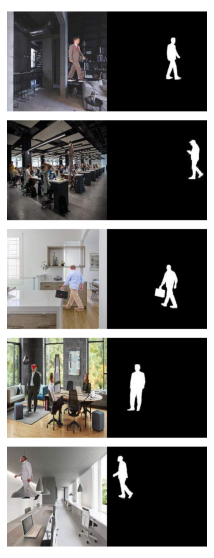

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob

img_paths = []
for i in range(1,6):
  f = glob.glob(f"/content/fg_bg/bg00"+str(i)+"/*jpg")[0]
  img_paths.append(f)
  img_paths.append(f.replace("fg_bg","fg_bg_masks"))

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def make_array():
    return np.array([np.asarray(ImageOps.expand(
        Image.open(f).convert('RGB'), border=(0, 10), fill='white')) for f in img_paths])

array = make_array()
result = gallery(array)
plt.figure(figsize=(22,10))
plt.axis("off")
plt.imshow(result)
plt.show()